![Memories Teach](https://lh3.google.com/u/2/d/11o4JyBYhHcmz-LSt63GpOs4lfW9j39T_=w1912-h954-iv1)


`Basic to Advance in Google colab's for image processing, pattern recognition and computer vision`

[Phonepaserth SISAYKEO]

Reference: visioncolab

Let's start by installing the relevant libraries.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.9 MB/s eta 0:00:00


In [ ]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.6/774.6 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 65.4 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import tqdm
import torch
import numpy as np
import torchvision
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.autograd import Variable
from pytorch_lightning import Trainer
from   torch.utils.data import DataLoader
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from transformers import ViTForImageClassification, ViTFeatureExtractor,AdamW

# Download the Data


In [ ]:
# Rock+Paper+Scissors: 3 classes (toy example)
# !wget https://www.dropbox.com/s/lz8ci7zwb3hbzlx/RockPaperScissors.zip
# !unzip -qq RockPaperScissors.zip
# fpath = 'RockPaperScissors/'

In [ ]:
# skin lesions: 2 classes

#!wget https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
#!unzip -qq exp0.zip
#fpath = 'exp0/'

In [ ]:
# skin lesions: 7 classes
!wget https://www.dropbox.com/s/nzrvuoos7sgl5dh/exp4val.zip
!unzip -qq exp4val.zip
fpath = ''

--2023-11-07 18:16:55--  https://www.dropbox.com/s/nzrvuoos7sgl5dh/exp4val.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6025:18::a27d:4512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/nzrvuoos7sgl5dh/exp4val.zip [following]
--2023-11-07 18:16:56--  https://www.dropbox.com/s/raw/nzrvuoos7sgl5dh/exp4val.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbf098daa97debc55785756053f.dl.dropboxusercontent.com/cd/0/inline/CHGvEj-f9tu24KYoQju-ciJP5h1qt1d78taGVYFVrRVXNDM2loauDn1hMjjeE0RVd3oAoI-pWi2IOSEMc9NNeKnO56axVtMW41f2imVRuIrKvNSn0qXdkOltewhfhqptWW4/file# [following]
--2023-11-07 18:16:56--  https://ucbf098daa97debc55785756053f.dl.dropboxusercontent.com/cd/0/inline/CHGvEj-f9tu24KYoQju-ciJP5h1qt1d78taGVYFVrRVXNDM2loauDn1hMjjeE0RVd3oAoI-pWi2IOSEMc9NNeKnO56axVtMW41f2imVRuIrKvNSn0qXdkOltewh

Next, convert the folder structure dataset into a PyTorch dataset format using PyTorch's ImageFolder dataset structure:

## Define the Model Parameters

To train this model, we will train in 3 epochs, with a batch size of 10 and a learning rate of 2e-5:

In [ ]:
EPOCHS        = 50
BATCH_SIZE    = 70
LEARNING_RATE = 2e-5
EARLY_STOP    = 10
img_size      = 224
img_size0     = int(1.05*img_size)

print(img_size0,' > ',img_size)

235  >  224


In [ ]:
EPOCHS        = 50
BATCH_SIZE    = 50
LEARNING_RATE = 2e-5
EARLY_STOP    = 10
img_size      = 224
img_size0     = int(1.0*img_size)

print(img_size0,' > ',img_size)

224  >  224


# Image Augmentation

[See more](https://pytorch.org/vision/stable/transforms.html) (pytorch help)

In [ ]:
# Options:
#    transforms.ToPILImage(),
#    transforms.Resize(256),
#    transforms.ColorJitter(),
#    transforms.RandomCrop(224),
#    transforms.RandomHorizontalFlip(),
#    transforms.ToTensor()



# Image Transformations
train_tf = transforms.Compose([
#    transforms.Resize((img_size0,img_size0)),
    transforms.RandomCrop((img_size,img_size)),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomVerticalFlip(),
#    transforms.ColorJitter(),
    transforms.ToTensor()
    ])

val_tf = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()])

test_tf = transforms.Compose([
    transforms.Resize((img_size,img_size)),
    transforms.ToTensor()])


train_ds = torchvision.datasets.ImageFolder('/content/'+fpath+'train/', transform = train_tf)
val_ds   = torchvision.datasets.ImageFolder('/content/'+fpath+'val/'  , transform = val_tf)
test_ds  = torchvision.datasets.ImageFolder('/content/'+fpath+'test/' , transform = test_tf)


## Define the Model

Here we define the model.

The model itself uses a linear layer on top of a pre-trained `ViTForImageClassification` given by framework PytorchLightning [See more](https://www.pytorchlightning.ai/index.html).

**Note:** The Vision Transformer pretrained model can be used as a regular PyTorch layer.

In [ ]:
class ViTLightningModule(pl.LightningModule):
    def __init__(self,feature_extractor, loss_func,num_classes=2):
        super(ViTLightningModule, self).__init__()

        self.vit = ViTForImageClassification.from_pretrained(feature_extractor,
                                                              num_labels=num_classes,
                                                             ignore_mismatched_sizes=True)
        self.save_hyperparameters()
        self.validation_step_outputs = None
        self.criterion = loss_func

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

    def common_step(self, batch, batch_idx):
        pixel_values,labels = batch
        logits = self(pixel_values)
        # probs = torch.softmax(logits, dim=1)

        loss = self.criterion(logits, labels)
        predictions = logits.argmax(dim=1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return predictions, loss, accuracy, logits

    def training_step(self, batch, batch_idx):
        _, loss, accuracy,_ = self.common_step(batch, batch_idx)
        self.log("train/train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train/train_accuracy", accuracy, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        preds, loss, accuracy, logits = self.common_step(batch, batch_idx)
        self.log("val/val_loss", loss, on_epoch=True)
        self.log("val/val_accuracy", accuracy, on_epoch=True)
        probs = torch.softmax(logits, dim=1)
        return preds,probs

    def test_step(self, batch, batch_idx):
        preds, loss, accuracy, logits = self.common_step(batch, batch_idx)
        xs, ys = batch
        self.log("test/test_loss", loss, on_step=False, on_epoch=True)
        self.log("test/test_accuracy", accuracy, on_step=False, on_epoch=True)
        probs = torch.softmax(logits, dim=1)
        return preds, probs

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
#         return optim.SGD(self.parameters(), lr=5e-3, momentum=0.9)
        # return torch.optim.AdamW(self.parameters(), lr=5e-5)
        return torch.optim.Adam(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader

We will use the pretrained Vision Transformer feature extractor, an Adam Optimizer, and a Cross Entropy Loss function.

In [ ]:
# Feature Extractor
#feature_extractor = 'microsoft/beit-base-patch16–224'
feature_extractor = 'google/vit-base-patch16-224-in21k'
#feature_extractor = 'google/vit-base-patch16-224'
#feature_extractor = 'facebook/deit-base-distilled-patch16-224'

# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()


# Define Model
model = ViTLightningModule(feature_extractor, loss_func, num_classes=len(train_ds.classes))

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


## Train the Model

In [ ]:
print("Number of train samples: ", len(train_ds))
print("Number of val   samples: ", len(val_ds))
print("Number of test  samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx)

train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = data.DataLoader(val_ds  , batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = data.DataLoader(test_ds , batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

early_stop_callback = EarlyStopping(
            monitor='val_loss',
            patience=EARLY_STOP,
            strict=False,
            verbose=False,
            mode='min'
        )

checkpoint_callback = ModelCheckpoint(
            save_top_k=1,
            monitor="val/val_loss",
            mode="min",
            dirpath="./model/",
            filename=f'best_model',
        )

trainer = Trainer(callbacks=[EarlyStopping(monitor='val/val_loss'),checkpoint_callback],log_every_n_steps=5,max_epochs=EPOCHS)
trainer.fit(model)
trainer.test()

Number of train samples:  7350
Number of val   samples:  1050
Number of test  samples:  210
Detected Classes are:  {'class_0': 0, 'class_1': 1, 'class_2': 2, 'class_3': 3, 'class_4': 4, 'class_5': 5, 'class_6': 6}


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params
--------------------------------------------------------
0 | vit       | ViTForImageClassification | 85.8 M
1 | criterion | CrossEntropyLoss          | 0     
--------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
343.216   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/model/best_model.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model/best_model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test/test_accuracy     │    0.7952380776405334     │
│      test/test_loss       │    0.6781333684921265     │
└───────────────────────────┴───────────────────────────┘

[{'test/test_loss': 0.6781333684921265,
  'test/test_accuracy': 0.7952380776405334}]

In [ ]:
def ComputeAccuracy(ds,trainedmodel):
  EVAL_BATCH = 1
  eval_loader  = data.DataLoader(ds, batch_size=EVAL_BATCH, shuffle=False, num_workers=4)
  # Disable grad
  with torch.no_grad():

    Nds   = len(ds)
    ypred = np.zeros((Nds,))
    ygt   = np.zeros((Nds,))
    i     = 0

    for inputs, target in eval_loader:


      # Send to appropriate computing device
      inputs = inputs.to(device)
      target = target.to(device)

      # Generate prediction
      prediction = trainedmodel(inputs)

      # Predicted class value using argmax
      predicted_class = np.argmax(prediction.cpu())
      ypred[i] = predicted_class
      ygt[i]   = target
      i        = i+1

  acc = np.sum(ypred==ygt)/i

  return acc

# Evaluation of Accuracy

In [ ]:
modelbest = ViTLightningModule.load_from_checkpoint('./model/best_model.ckpt')
modelbest.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTLightningModule(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
           

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

p = count_parameters(model)
print(f'{p/1e6:8.4f}')


 85.8040


In [ ]:
ds = train_ds
acc_train = ComputeAccuracy(ds,modelbest)
print('Train Accuracy =  %.4f' % acc_train , 'in %d images.' % len(ds))

ds = val_ds
acc_val = ComputeAccuracy(ds,modelbest)
print('  Val Accuracy =  %.4f' % acc_val , 'in %d images.' % len(ds))

ds = test_ds
acc_test = ComputeAccuracy(ds,modelbest)
print(' Test Accuracy =  %.4f' % acc_test, 'in %d images.' % len(ds))

Train Accuracy =  0.9608 in 7350 images.
  Val Accuracy =  0.8171 in 1050 images.
 Test Accuracy =  0.7952 in 210 images.


# Evaluation on a random testing image

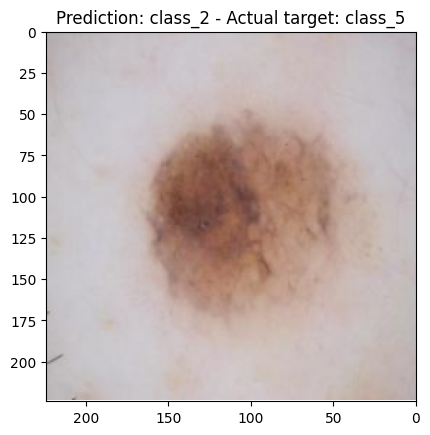

In [ ]:
EVAL_BATCH = 1
eval_loader  = data.DataLoader(val_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4)
# Disable grad
with torch.no_grad():

  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  # print(inputs.shape)
  # print(inputs[0].size())
  # inputs = inputs[0]
  # Save original Input
  originalInput = inputs[0].permute(1, 2, 0)

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)

  # Generate prediction
  prediction = modelbest(inputs)


  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())

  value_predicted = list(test_ds.class_to_idx.keys())[list(test_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(test_ds.class_to_idx.keys())[list(test_ds.class_to_idx.values()).index(target)]

  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()